# Preprocess LLC4320 data

This program is to preprcess the LLC4320 data using the xmitgcm llcreader package. 

Note that it needs the 'submeso_env' environment

In [1]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import xrft
import xgcm
import gcm_filters
import matplotlib.pyplot as plt
import xesmf as xe
import gsw_xarray as gsw

/ext3/miniconda3/lib/python3.9/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.22.4 (/ext3/miniconda3/lib/python3.9/site-packages), Requirement.parse('numpy<1.22,>=1.18'), {'numba'}))'.
  numba.core.entrypoints.init_all()


In [ ]:
ds_T = model.get_dataset(varnames=['Theta'], type='latlon')
ds_S = model.get_dataset(varnames=['Salt'], type='latlon')

Text(0, 0.5, 'm')

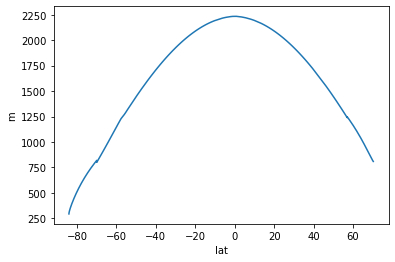

In [28]:
plt.plot(ds_T.YC.mean(dim='i'),ds_T.dxF.mean(dim='i'))
plt.xlabel('lat')
plt.ylabel('m')

In [5]:
ds_W = model.get_dataset(varnames=['W'], type='latlon')

In [6]:
sel_area = np.logical_and(np.logical_and(ds_T.XC>25, ds_T.XC<45 ),
                           np.logical_and(ds_T.YC>-55, ds_T.YC<-49 ))

In [7]:
X = ds_T.XC.where(sel_area, drop=True)
Y = ds_T.YC.where(sel_area, drop=True)

In [8]:
ds_sel_T = ds_T.Theta.where(sel_area, drop=True)
ds_sel_S = ds_S.Salt.where(sel_area, drop=True)

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * ax

In [9]:
ds_sel_W = ds_W.W.where(sel_area, drop=True)

#interp W grid onto T grid
ds_sel_W_interp = ds_sel_W.interp(k_l=ds_sel_T.k)

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [10]:
# pressure
P_sel = gsw.p_from_z(ds_sel_T.Z, ds_sel_T.YC)

# gravity
g_sel = gsw.grav(ds_sel_T.YC, P_sel)

In [11]:
# Conservative Temperature (CT)
CT_sel = gsw.CT_from_pt(ds_sel_S, ds_sel_T)

In [12]:
# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0_sel = gsw.sigma0(ds_sel_S, CT_sel)

In [13]:
# reference density 
rho0 = 1000 #kg/m^3

# buoyancy
b_sel = -g_sel*sigma0_sel/rho0

In [23]:
b_sel = b_sel.rename('b')

In [14]:
# sigma0 at 10m depth for reference
sigma0_sel_10m = sigma0_sel.isel(k=6).broadcast_like(sigma0_sel).chunk(chunks={'time': 1, 'k':1, 'j': sigma0_sel.j.size, 'i': sigma0_sel.i.size})

In [15]:
delta_sigma = sigma0_sel - sigma0_sel_10m

In [16]:
H_0 = sigma0_sel.Z.broadcast_like(sigma0_sel.isel(time=0))

In [17]:
# mixed layer depth

H_MLD_0 = H_0.where(delta_sigma<=0.03).min(dim="k",skipna=True).rename('Mixed Layer Depth')

/ext3/miniconda3/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


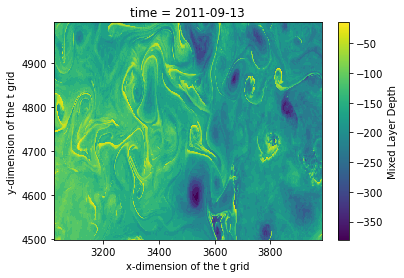

In [26]:
H_MLD_0.isel(time=0).plot()

# Filtering

In [32]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In [33]:
# define filter region as slightly larger that sel_area to ensure sufficient padding for laplacian operator

sel_area_filt = np.logical_and(np.logical_and(ds_T.XC>24, ds_T.XC<46 ),
                           np.logical_and(ds_T.YC>-56, ds_T.YC<-48 ))

sel_area_filt_g = np.logical_and(np.logical_and(ds_T.XG>24-0.02, ds_T.XG<46 ),
                           np.logical_and(ds_T.YG>-56, ds_T.YG<-48 ))

In [34]:
# filter w and b fields
w_sel_filt = ds_W.W.where(sel_area_filt, drop=True).interp(k_l=ds_sel_T.k)

ds_sel_T_filt = ds_T.Theta.where(sel_area_filt, drop=True)
ds_sel_S_filt = ds_S.Salt.where(sel_area_filt, drop=True)

# pressure
P_sel_filt = gsw.p_from_z(ds_sel_T_filt.Z, ds_sel_T_filt.YC)





/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * ax

NameError: name 'g_sel_filt' is not defined

In [35]:
# gravity
g_sel_filt = gsw.grav(ds_sel_T_filt.YC, P_sel_filt)

In [ ]:


# Conservative Temperature (CT)
CT_sel_filt = gsw.CT_from_pt(ds_sel_S_filt, ds_sel_T_filt)

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0_sel_filt = gsw.sigma0(ds_sel_S_filt, CT_sel_filt)

# reference density 
rho0 = 1000 #kg/m^3

In [36]:


# buoyancy
b_sel_filt = -g_sel_filt*sigma0_sel_filt/rho0
b_sel_filt = b_sel_filt.rename('b')

# sigma0 at 10m depth for reference
sigma0_sel_filt_10m = sigma0_sel_filt.isel(k=6).broadcast_like(sigma0_sel_filt).chunk(chunks={'time': 1, 'k':1, 'j': sigma0_sel_filt.j.size, 'i': sigma0_sel_filt.i.size})

delta_sigma_filt = sigma0_sel_filt - sigma0_sel_filt_10m

b_sel_filt = b_sel_filt.where(sel_area_filt, drop=True)

In [41]:
wet_mask_sel = np.logical_not(np.isnan(ds_sel_T_filt.Depth)).where(sel_area_filt, drop=True)
wet_mask = xr.DataArray(wet_mask_sel.values,coords={'j':wet_mask_sel.j.values , 'i': wet_mask_sel.i.values})

area= ds_sel_T_filt.rA

In [42]:
# UV dataset for i_j, j_g data

ds_UV = model.get_dataset(varnames=['U', 'V'], type='latlon')

ds_UV_sel_filt = ds_UV.where(sel_area_filt, drop=True).where(sel_area_filt_g, drop=True)

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/ext3/mini

In [43]:
dxw = xr.DataArray(
    data=ds_UV_sel_filt.dxC, 
    coords={'i':b_sel_filt.i,'j':b_sel_filt.j}, 
    dims=('j','i')
)

dyw = xr.DataArray(
    data=ds_UV_sel_filt.dyC, 
    coords={'i':b_sel_filt.i,'j':b_sel_filt.j}, 
    dims=('j','i')
)


dxs = xr.DataArray(
    data=ds_UV_sel_filt.dxG, 
    coords={'i':b_sel_filt.i,'j':b_sel_filt.j}, 
    dims=('j','i')
)


dys = xr.DataArray(
    data=ds_UV_sel_filt.dyG, 
    coords={'i':b_sel_filt.i,'j':b_sel_filt.j}, 
    dims=('j','i')
)


In [44]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(1246.7798, dtype=float32)

## Factor scale 24 filter

In [45]:
dx_max = max(dxw.max(),dys.max()) #removed ,dyw.max(),dxs.max()
dx_max = dx_max.values
dx_max

kappa_w_fac = dxw * dxw / (dx_max * dx_max) 
kappa_s_fac = dys * dys / (dx_max * dx_max)

In [46]:
filter_factor24 = gcm_filters.Filter(
    filter_scale=24 * dx_max, # factor of 24
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w_fac, 'kappa_s': kappa_s_fac
    }
)
filter_factor24

Filter(filter_scale=37189.4736328125, dx_min=array(1246.7798, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=33, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

## Define Mesoscale and submesoscale fields

In [56]:
# masked data
b_sel_filt_masked = b_sel_filt.where(wet_mask)
w_sel_filt_masked = w_sel_filt.where(wet_mask)

# full field
b_sel_full_0 = b_sel_filt.isel(time=0).where(sel_area, drop=True)
w_sel_full_0 = w_sel_filt.isel(time=0).where(sel_area, drop=True)


In [93]:
# full field w'b' averaged over mixed layer

wb_full_0 =  b_sel_full_0*w_sel_full_0

wb_full_0_MLD = wb_full_0.where(delta_sigma.isel(time=0)<=0.03).mean(dim='k',skipna=True)

In [58]:
# Mesoscale
b_m_0 = filter_factor24.apply(b_sel_filt_masked.isel(time=0), dims=['i', 'j']).where(sel_area, drop=True)
w_m_0 = filter_factor24.apply(w_sel_filt_masked.isel(time=0), dims=['i', 'j']).where(sel_area, drop=True)


# Submesoscale
b_s_0 =  b_sel_full_0 - b_m_0
w_s_0 =  w_sel_full_0 - w_m_0

In [91]:
# averge submesoscale w'b' over mixed layer

wb_s_0 =  b_s_0*w_s_0

wb_s_0_MLD = wb_s_0.where(delta_sigma_filt.isel(time=0)<=0.03).mean(dim='k',skipna=True) 

In [69]:
# mesoscale buoyancy gradient 

b_m_0_diff_i = b_m_0.differentiate("i")
b_m_0_diff_j = b_m_0.differentiate("j")

b_m_grad_sqr_0 = np.square(b_m_0_diff_i) + np.square(b_m_0_diff_j)

In [83]:
# average mesoscale buoyancy gradient over the mixed layer

b_m_grad_sqr_0_MLD = b_m_grad_sqr_0.where(delta_sigma_filt.isel(time=0)<=0.03).mean(dim='k',skipna=True) 

In [74]:
# full buoyancy gradient 

b_full_0_diff_i = b_sel_full_0.differentiate("i")
b_full_0_diff_j = b_sel_full_0.differentiate("j")

b_full_grad_sqr_0 = np.square(b_full_0_diff_i) + np.square(b_full_0_diff_j)

In [86]:
# average full buoyancy gradient over the mixed layer

b_full_grad_sqr_0_MLD = b_full_grad_sqr_0.where(delta_sigma_filt.isel(time=0)<=0.03).mean(dim='k',skipna=True) 

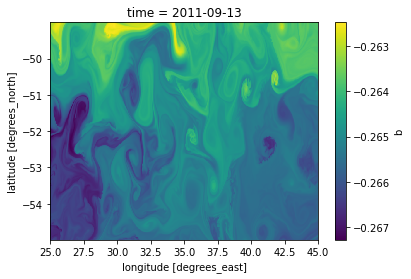

In [72]:
# plot of averge buoyancy gradient
b_avg = b_sel.where(delta_sigma<=0.03).mean(dim='k',skipna=True) 

b_avg.isel(time=0).plot(x='XC', y='YC')

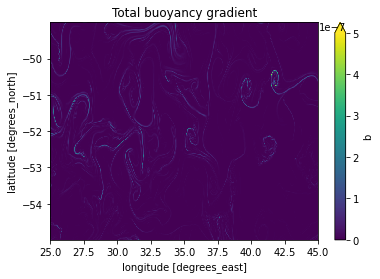

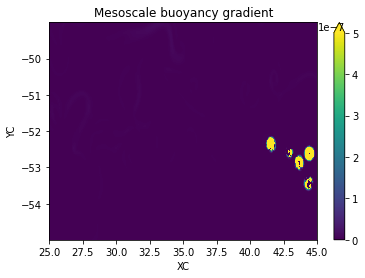

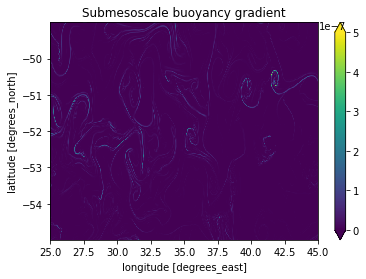

In [99]:
# plot buoyancy gradient

b_full_grad_sqr_0_MLD.plot(x='XC', y='YC', vmin=0, vmax=5e-7)
plt.title('Total buoyancy gradient')
plt.show()

b_m_grad_sqr_0_MLD.plot(x='XC', y='YC', vmin=0, vmax=5e-7)
plt.title('Mesoscale buoyancy gradient')
plt.show()

(b_full_grad_sqr_0_MLD-b_m_grad_sqr_0_MLD).plot( x='XC', y='YC', vmin=0, vmax=5e-7)
plt.title('Submesoscale buoyancy gradient')
plt.show()

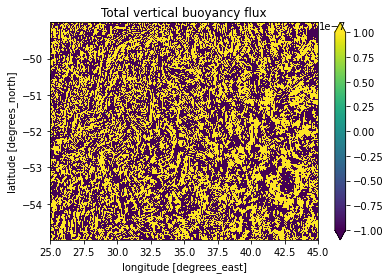

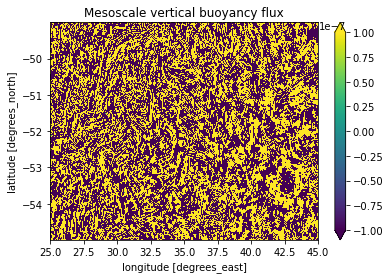

AttributeError: 'Text' object has no property 'vmin'

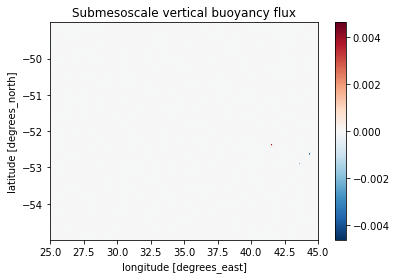

In [100]:
# plot w'b' gradient

wb_full_0_MLD.plot(x='XC', y='YC', vmin=-1e-7, vmax=1e-7)
plt.title('Total vertical buoyancy flux')
plt.show()

(wb_full_0_MLD-wb_s_0_MLD).plot(x='XC', y='YC', vmin=-1e-7, vmax=1e-7)
plt.title('Mesoscale vertical buoyancy flux')
plt.show()

wb_s_0_MLD.plot( x='XC', y='YC', vmin=-1e-7, vmax=1e-7)
plt.title('Submesoscale vertical buoyancy flux')
plt.show()

In [ ]:
wb_s_0_MLD.plot( x='XC', y='YC', vmin=-1e-7, vmax=1e-7)
plt.title('Submesoscale vertical buoyancy flux')
plt.show()

# Variability

In [ ]:
# buoyancy gradient histogram 
b_m_grad_sqr_0_MLD.plot.hist(histtype='step',density=True, bins=20,linewidth=3,label='mesoscale')
(b_full_grad_sqr_0_MLD-b_m_grad_sqr_0_MLD).plot.hist(histtype='step',density=True, bins=20,linewidth=3,label='submesoscale')
b_full_grad_sqr_0_MLD.plot.hist(histtype='step',density=True, bins=20,linewidth=3,label='Total')

plt.legend()
plt.title('Histogram of buoyancy gradient')



In [ ]:
# w'b' histogram 
(wb_full_0_MLD-wb_s_0_MLD).plot.hist(histtype='step',density=True, bins=20,linewidth=3,label='mesoscale')
wb_s_0_MLD.plot.hist(histtype='step',density=True, bins=20,linewidth=3,label='submesoscale')
wb_full_0_MLD.plot.hist(histtype='step',density=True, bins=20,linewidth=3,label='Total')

plt.legend()
plt.title('Histogram of vertical buoyancy flux')

# Coarse graining to 1/4 degree

In [ ]:
# building regridder: coarse grain to 1/4 degree
ds_out_qurter = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-54.9, -49, 0.25)),
        "lon": (["lon"], np.arange(25.1, 45, 0.25)),
    }
)

regridder_quarter = xe.Regridder(ds_sel_surf.isel(time=0), ds_out_qurter, "bilinear", periodic=False, reuse_weights=False)
regridder_quarter

In [ ]:
b_m_grad_sqr_0_MLD_quarter = regridder_quarter(b_m_grad_sqr_0_MLD)
wb_s_0_MLD_quarter = regridder_quarter(wb_s_0_MLD)

In [ ]:
b_m_grad_sqr_0_MLD_quarter.plot(x='lon', y='lat')
plt.title('1/4deg mesoscale buoyancy gradient')
plt.show()

wb_s_0_MLD_quarter.plot(x='lon', y='lat')
plt.title('1/4deg submesoscale vertical buoyancy flux')
plt.show()
